# Monet generator with GAN

In the project I will attempt to create a deep neural network to generate images that are similar to Monet paintings. For this I will be using Generative Adversarial Networks (GANs). This is part of a Kaggle competition that is available through the following link: https://www.kaggle.com/competitions/gan-getting-started/overview

This project is also available on my GitHub using the following link: https://github.com/mohosb/monet_generator

## Data loading, preprocessing and EDA

In the following section we create a dataset and dataloader object to load and preprocess the images, so we can take a look at them and later, feed them to the neural networks.

There are exactly 300 images of Monet paintings and every image is 256x256 pixels with RGB channels. This is a reasonable images size. Not too big to require and incredibly large model but large enough so that we can clearly see what the images are about.

In [1]:
import torch
import torchvision
import os
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import shutil

In [2]:
class UnlabeledImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.all_images = sorted(os.listdir(root))

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root, self.all_images[idx])).convert('RGB')
        return self.transform(image)

In [3]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

train_ds = UnlabeledImageFolder(root='/kaggle/input/gan-getting-started/monet_jpg', transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=50, shuffle=True, num_workers=0)

In [4]:
print(len(train_ds))
print(train_ds[0].shape)

300
torch.Size([3, 256, 256])


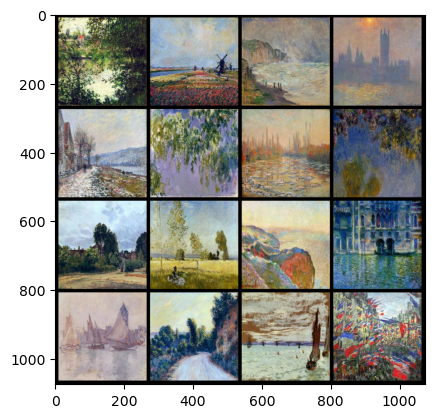

In [5]:
plt.imshow(torchvision.utils.make_grid(next(iter(train_loader))[:16], nrow=4, padding=10).permute(1, 2, 0));

## Model building and training

We will create a discriminator, which is a binary classifier that tries to differentiate generated fake images from real ones. This model will gradually decrease the spacial dimensions while increasing the number of channels, using residual blocks with instance normalization and convolutions.

The other model will be the generator, that tries to create images from latent space representations that can fool the discriminator, so that it classifies the fake images as real ones. This way, the generator should learn the distribution of the original dataset. The generator model will contain residual blocks that gradually increase the spacial dimension and decrease the channel dimensions until we get an image of desired size. The up sampling blocks use instance normalizations and transposed convolutions.

In [6]:
class DownSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth_factor=1):
        assert depth_factor >= 1
        super().__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2, True)
        ]
        for _ in range(depth_factor - 1):
            layers += [
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.InstanceNorm2d(out_channels, affine=True),
                nn.LeakyReLU(0.2, True)
            ]
        self.layers = nn.Sequential(*layers)
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0, bias=False)

    def forward(self, x):
        s = x.clone()
        x = self.layers(x)
        x = x + self.skip(s)
        return x


class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth_factor=1):
        assert depth_factor >= 1
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.ReLU(True)
        ]
        for _ in range(depth_factor - 1):
            layers += [
                nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.InstanceNorm2d(out_channels, affine=True),
                nn.ReLU(True)
            ]
        self.layers = nn.Sequential(*layers)
        self.skip = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0, bias=False)

    def forward(self, x):
        s = x.clone()
        x = self.layers(x)
        x = x + self.skip(s)
        return x


class Discriminator(torch.nn.Module):
    def __init__(self, num_blocks=1, depth_factor=1, width_factor=1):
        assert num_blocks >= 1 and depth_factor >= 1 and width_factor >= 1
        super().__init__()
        num_channels = [16] + [2 ** (4 + i) * width_factor for i in range(num_blocks - 1)]
        self.head = nn.Conv2d(3, num_channels[0], kernel_size=3, stride=1, padding=0, bias=False)
        self.blocks = nn.Sequential(
            *[DownSampleBlock(num_channels[i - 1], num_channels[i], depth_factor) for i in range(1, len(num_channels))]
        )
        self.tail = nn.Sequential(
            nn.Linear(num_channels[-1], 1),
            nn.Sigmoid()
        )
        self.init_parameters()

    def forward(self, x):
        x = self.head(x)
        x = self.blocks(x)
        x = torch.mean(x, (2, 3))
        x = self.tail(x)
        return x

    @torch.no_grad()
    def init_parameters(self):
        for m in self.modules():
            class_name = m.__class__.__name__
            if class_name.find('Conv') != -1:
                torch.nn.init.normal_(m.weight, 0.0, 0.02)
            elif class_name.find('BatchNorm') != -1 or class_name.find('InstanceNorm') != -1:
                torch.nn.init.normal_(m.weight, 1.0, 0.02)
                torch.nn.init.constant_(m.bias, 0)


class Generator(torch.nn.Module):
    def __init__(self, latent_size, img_size, depth_factor=1, width_factor=1):
        super().__init__()
        self.latent_size = latent_size
        num_channels = [16] + [2 ** (4 + i) * width_factor for i in range(int(np.log2(img_size)))]
        num_channels = num_channels[::-1]
        self.head = nn.ConvTranspose2d(latent_size, num_channels[0], kernel_size=1, stride=1, padding=0, bias=False)
        self.blocks = nn.Sequential(
            *[UpSampleBlock(num_channels[i - 1], num_channels[i], depth_factor) for i in range(1, len(num_channels))]
        )
        self.tail = nn.Sequential(
            nn.ConvTranspose2d(num_channels[-1], 3, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        self.init_parameters()

    def forward(self, x):
        x = self.head(x[..., None, None])
        x = self.blocks(x)
        x = self.tail(x)
        return x

    @torch.no_grad()
    def init_parameters(self):
        for m in self.modules():
            class_name = m.__class__.__name__
            if class_name.find('Conv') != -1:
                torch.nn.init.normal_(m.weight, 0.0, 0.02)
            elif class_name.find('BatchNorm') != -1 or class_name.find('InstanceNorm') != -1:
                torch.nn.init.normal_(m.weight, 1.0, 0.02)
                torch.nn.init.constant_(m.bias, 0)

    @torch.no_grad()
    def get_random_latent_vector(self, batch_size, device='cpu'):
        return torch.randn(batch_size, self.latent_size, device=device)

In [7]:
def train_gan(model_g, model_d, opt_g, opt_d, train_loader, num_epochs=1):
    assert next(model_g.parameters()).device == next(model_d.parameters()).device
    device = next(model_g.parameters()).device
    loss_fn = torch.nn.BCELoss()
    model_d.train()
    model_g.train()

    num_batches = len(train_loader)
    for epoch_idx in range(num_epochs):
        print(f'{epoch_idx + 1}/{num_epochs} epoch:')
        for batch_idx, real_data in enumerate(train_loader):
            opt_d.zero_grad()
            opt_g.zero_grad()
            batch_size = real_data.size(0)

            real_data = real_data.to(device)
            fake_data = model_g(model_g.get_random_latent_vector(batch_size, device))
            labels_real = torch.ones(batch_size, 1, device=device)
            labels_fake = torch.zeros(batch_size, 1, device=device)

            # Train discriminator with real and fake data
            output_real = model_d(real_data)
            loss_d_real = loss_fn(output_real, labels_real)
            loss_d_real.backward()
            output_fake = model_d(fake_data.detach())
            loss_d_fake = loss_fn(output_fake, labels_fake)
            loss_d_fake.backward()
            opt_d.step()
            loss_d = loss_d_real + loss_d_fake
            #acc_d = torch.cat([output_real.round() == labels_real, output_fake.round() == labels_fake]).cpu().numpy().mean()

            # Train generator
            output = model_d(fake_data)
            loss_g = loss_fn(output, labels_real)
            loss_g.backward()
            opt_g.step()
            #acc_g = (output.round() == labels_real).cpu().numpy().mean()

            #print(f'\t{batch_idx + 1}/{num_batches} batch - D loss: {loss_d.item():.4f}, G loss: {loss_g.item():.4f}, D accuracy: {acc_d:.4f}, G accuracy: {acc_g:.4f}')
            print(f'\t{batch_idx + 1}/{num_batches} batch - D loss: {loss_d.item():.4f}, G loss: {loss_g.item():.4f}')

In [8]:
#device = torch.device('cpu')
#device = torch.device('mps')
device = torch.device('cuda')

In [9]:
generator = Generator(128, 256, depth_factor=2, width_factor=2).to(device)
discriminator = Discriminator(6, depth_factor=1, width_factor=1).to(device)

optimizer_g = torch.optim.AdamW(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_d = torch.optim.AdamW(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

train_gan(generator, discriminator, optimizer_g, optimizer_d, train_loader, 10)

1/10 epoch:
	1/6 batch - D loss: 1.4135, G loss: 0.8707
	2/6 batch - D loss: 1.4100, G loss: 1.7752
	3/6 batch - D loss: 1.1252, G loss: 1.7896
	4/6 batch - D loss: 0.7346, G loss: 2.1008
	5/6 batch - D loss: 0.4267, G loss: 3.0651
	6/6 batch - D loss: 0.2650, G loss: 2.8078
2/10 epoch:
	1/6 batch - D loss: 0.2065, G loss: 4.5389
	2/6 batch - D loss: 0.1058, G loss: 4.4163
	3/6 batch - D loss: 0.1082, G loss: 5.0336
	4/6 batch - D loss: 0.0928, G loss: 4.6697
	5/6 batch - D loss: 0.1021, G loss: 6.2438
	6/6 batch - D loss: 0.1197, G loss: 2.1346
3/10 epoch:
	1/6 batch - D loss: 1.2050, G loss: 9.4299
	2/6 batch - D loss: 3.6917, G loss: 1.0732
	3/6 batch - D loss: 1.3896, G loss: 3.5525
	4/6 batch - D loss: 0.4550, G loss: 2.6363
	5/6 batch - D loss: 0.7413, G loss: 3.6243
	6/6 batch - D loss: 0.6661, G loss: 2.4704
4/10 epoch:
	1/6 batch - D loss: 1.4602, G loss: 3.6543
	2/6 batch - D loss: 1.3860, G loss: 2.3965
	3/6 batch - D loss: 1.3301, G loss: 0.8916
	4/6 batch - D loss: 1.6062,

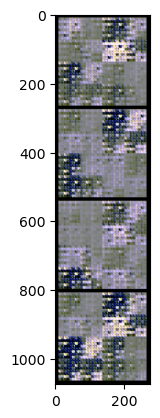

In [10]:
with torch.no_grad():
    generator.eval()
    latent_vector = generator.get_random_latent_vector(4, device)
    plt.imshow(torchvision.utils.make_grid(generator(latent_vector).cpu(), nrow=1, padding=10).permute(1, 2, 0))

## Discussion and conclusion

Although this notebook does not contain everything, I tried several generator and discriminator model architectures, but every one of them failed. The generator model commonly collapsed and started to generate the exact same image regardless of the input latent vector, and the discriminator always beats the generator. First I tried to increase the depth and with of the generator to better compete with the discriminator, but I run out of computational resources very quicly. After that, I tried to reduce the discriminator depth and width, but then, it became so simple for the generator to fool the discriminator, that the generated images basically looked like some kind of noise.

In conclusion, although currently the best generator can not even generate images that remotely look like paintings, I am certain that with a good hyperparameter configuration and a big enough generator-discriminator size, the problem could be solved.

In [12]:
NUM_IMAGES = 7500

os.makedirs('./images', exist_ok=True)

generator.eval()
for i in range(NUM_IMAGES):
    latent_vector = generator.get_random_latent_vector(1, device)
    img = generator(latent_vector).cpu()[0]
    torchvision.utils.save_image(img, f'./images/{i}.jpg')
shutil.make_archive('images', 'zip', 'images')

'/kaggle/working/images.zip'